### PCA modeling

- Do a lot of PCA calculations
- fit cos -> euclidean distance curves to them

In [1]:
import dataclasses
import pickle
import random
import numpy as np
import os
import re
import time
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist, pdist, squareform, euclidean
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize
from gensim import models

from matplotlib import pyplot as plt
from typing import *

In [2]:
def read_goog_file(data_dir: str='.', size: int=None, clean=False) -> Tuple[List[str], np.array]:
    """
    Read the 3M vectors of length 300 from the Google News dataset. 
    
    Returns a list of words and a matrix of vectors. Indices match between the two.
    The vectors are normalized to unit, because Semantle uses cos distance which ignores magnitude.
    
    data_dir: dir that contains source files
    'size' and 'clean' will produce fewer rows.
    size: a number smaller than 3 million. Stops reading once we hit that many rows.
    clean: only keep high-quality words (no spaces, numbers, capital letters, or non-ascii.)
    """
    vec_file = os.path.join(data_dir + 'GoogleNews-vectors-negative300.bin')
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    vecs = []
    w_list = []
    
    # subset setup
    if clean:
        ascii_subset = re.compile(r'^[a-z]+$')

    # iterate over file
    for w in words:
        if clean:
            # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
            if not ascii_subset.match(w):
                continue
        w_list.append(w)
        vecs.append(kv[w])
    
    # combine, normalize, return
    mat = np.vstack(vecs)
    return w_list, normalize(mat, axis=1)



In [3]:
data_dir = '/mnt/Spookley/datasets/semantle/'
w_list, mat_orig = read_goog_file(data_dir=data_dir, clean=True)
word_to_idx = {w:i for i, w in enumerate(w_list)}
print('w_list size:', len(w_list), 'mat shape:', mat_orig.shape)

w_list size: 155060 mat shape: (155060, 300)


In [4]:
def do_pca(mat_orig, n_dims=100):
    pca = PCA(n_components=n_dims)
    mat_pca = pca.fit_transform(mat_orig)
    return mat_pca

n_rows = len(w_list)
pca_mats = {}
for n_dims in [10, 25, 50, 60, 70, 75, 80, 90, 100, 200, 300]:
    t0 = time.time()
    mat_pca = do_pca(mat_orig, n_dims)
    outfile = os.path.join(data_dir, 'pca_{}rows_{}dims.npy'.format(n_rows, n_dims))
    pca_mats[n_dims] = mat_pca
    np.save(outfile, mat_pca)
    print(n_dims, 'dims pca computed on', n_rows, 'rows in', round(time.time()-t0, 3), 'seconds.')

10 dims pca computed on 155060 rows in 0.442 seconds.
25 dims pca computed on 155060 rows in 0.695 seconds.
50 dims pca computed on 155060 rows in 0.714 seconds.
60 dims pca computed on 155060 rows in 0.742 seconds.
70 dims pca computed on 155060 rows in 0.806 seconds.
75 dims pca computed on 155060 rows in 0.883 seconds.
80 dims pca computed on 155060 rows in 0.938 seconds.
90 dims pca computed on 155060 rows in 1.025 seconds.
100 dims pca computed on 155060 rows in 1.111 seconds.
200 dims pca computed on 155060 rows in 1.839 seconds.
300 dims pca computed on 155060 rows in 0.629 seconds.


## Distance fitting

OK, now we have some PCAs. 
We want to see how well cosine distances in mat_orig map to Euclidean distances in each mat_pca.

We'll use a benchmark set of word pairs. The benchmark has lots of examples of 'close' pairs (much more than you'd get by chance) so it ensures we've captured local structure as well as global.

Random pairs would make for a poor benchmark (see histograms below).

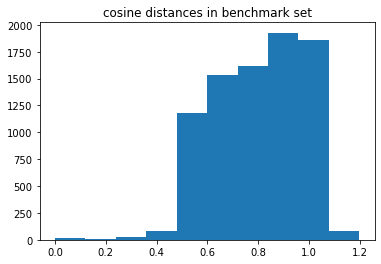

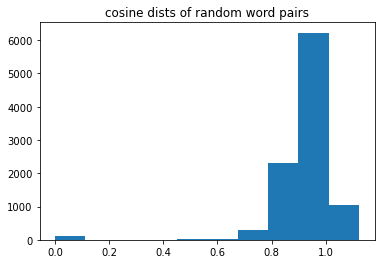

In [5]:
# load benchmark

@dataclasses.dataclass
class WordPair():
    w1: str
    w2: str
    dist: float  # these are cos dists
    
    def __str__(self):
        return '{} -> {}: {}'.format(self.w1, self.w2, self.dist)

with open(os.path.join(data_dir, 'word_pairs.pkl'), 'rb') as fh:
    word_pairs = pickle.load(fh)

plt.hist([wp.dist for wp in word_pairs])
plt.title('cosine distances in benchmark set')
plt.show()

submat = mat_orig[5000:5100, :]
submat_dists = cdist(submat, submat, metric='cosine').reshape(-1)
plt.hist(submat_dists)
plt.title('cosine dists of random word pairs')
plt.show()

### Test each PCA on the benchmark

You'll see some vertical stripes in the point clouds. Those are just artifacts of binning in the benchmark, safe to ignore.

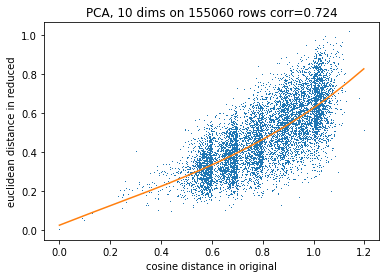

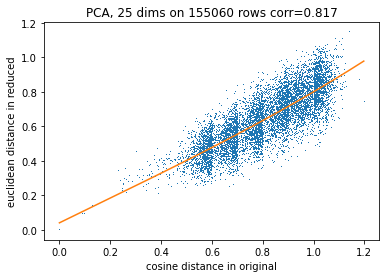

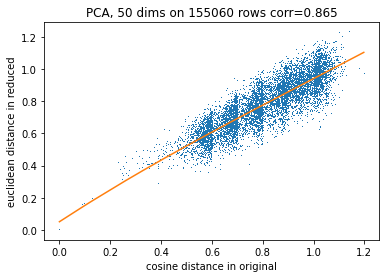

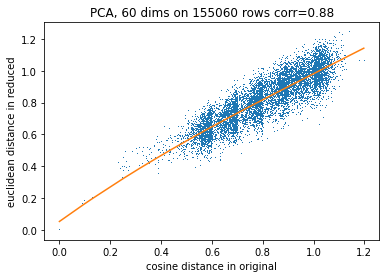

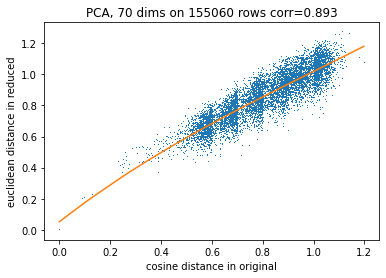

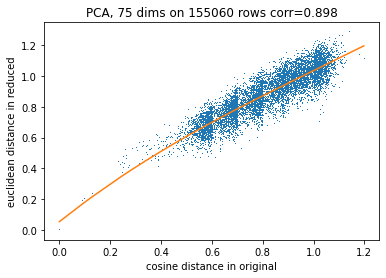

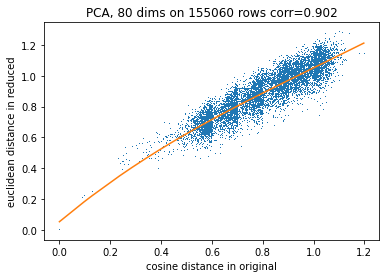

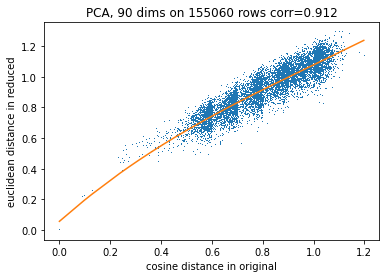

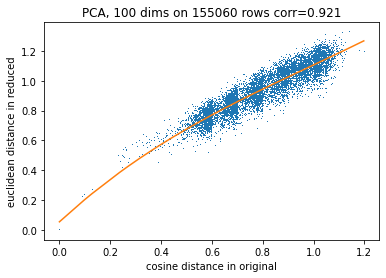

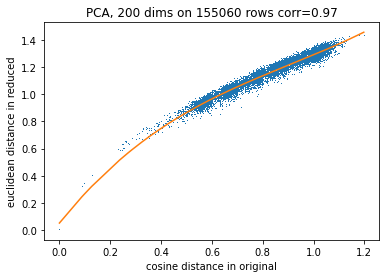

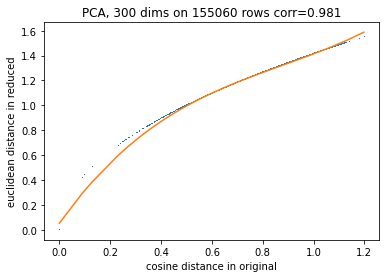

300-dim PCA is the same as no PCA, see:


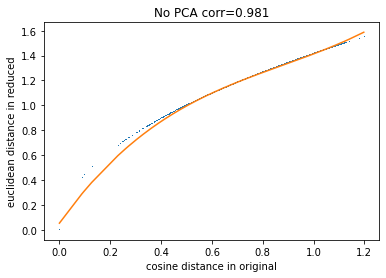

In [6]:
def make_plot(cos_dists, euclidean_dists, title):
    cc = round(np.corrcoef(cos_dists, euclidean_dists)[0,1], 3)
    pf = np.polyfit(cos_dists, euclidean_dists, 3)
    polyfunc = np.poly1d(pf)
    fit_line = polyfunc(np.array(sorted(cos_dists)))
    
    plt.plot(cos_dists, euclidean_dists, ',')
    plt.plot(sorted(cos_dists), fit_line, '-')
    plt.title(title + ' corr={}'.format(cc))
    plt.xlabel('cosine distance in original')
    plt.ylabel('euclidean distance in reduced')
    plt.show()
    return pf

pfs = {}
for n_dims in [10, 25, 50, 60, 70, 75, 80, 90, 100, 200, 300]:
    fn = os.path.join(data_dir, 'pca_{}rows_{}dims.npy'.format(n_rows, n_dims))
    mat_pca = np.load(fn)
    cos_dists = []  # cos dists, from benchmark
    pca_dists = []  # euclidean dists in this PCA
    for wp in word_pairs:
        cos_dists.append(wp.dist)
        i1 = word_to_idx[wp.w1]
        i2 = word_to_idx[wp.w2]
        pca_dist = euclidean(mat_pca[i1, :], mat_pca[i2, :])
        pca_dists.append(pca_dist)
    
    title = 'PCA, {} dims on {} rows'.format(n_dims, n_rows)
    pf = make_plot(cos_dists, pca_dists, title)
    pfs[n_dims] = pf

# save the curve fits, the solver will need them
fn = os.path.join(data_dir, 'pca_curve_fits_{}rows.pkl'.format(n_rows))
with open(fn, 'wb') as fh:
    pickle.dump(pfs, fh)
    
print('300-dim PCA is the same as no PCA, see:')
cos_dists = []
eu_dists = []
for wp in word_pairs:
    cos_dists.append(wp.dist)
    i1 = word_to_idx[wp.w1]
    i2 = word_to_idx[wp.w2]
    eu_dist = euclidean(mat_orig[i1, :], mat_orig[i2, :])
    eu_dists.append(eu_dist)

n_dims = ''
pf = make_plot(cos_dists, eu_dists, title='No PCA')
